# Resnet from scratch - CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *

## Data

In [3]:
PATH = "data/cifar10/"
os.makedirs(PATH, exist_ok=True)

### Calculate the mean and stdv of every channel for normalisation:

In [4]:
folder_names = os.listdir(f'{PATH}train/')

In [5]:
classes = tuple(folder_names)
classes

('ship',
 'cat',
 'truck',
 'bird',
 'horse',
 'automobile',
 'frog',
 'dog',
 'airplane',
 'deer')

In [6]:
file_names = [os.listdir(f'{PATH}train/' + folder) for folder in folder_names]

In [7]:
file_names = [[folder_names[i] + "/" + file_name for file_name in file_names[i]] for i in range(len(folder_names))]
file_names = list(itertools.chain(*file_names))

In [8]:
images = np.array([np.array(Image.open(PATH + 'train/' + fname)) for fname in file_names])

In [9]:
images.shape

(50000, 32, 32, 3)

In [10]:
stats = (np.array([images[:,:,:,0].mean()/255, images[:,:,:,1].mean()/255, images[:,:,:,2].mean()/255]), np.array([images[:,:,:,0].std()/255, images[:,:,:,1].std()/255, images[:,:,:,2].std()/255]))

In [11]:
stats

(array([0.4914 , 0.48216, 0.44653]), array([0.24703, 0.24349, 0.26159]))

In [12]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [13]:
bs = 256

### Let's take a look at the data

In [19]:
data = get_data(32, 4)

In [20]:
x, y = next(iter(data.trn_dl))

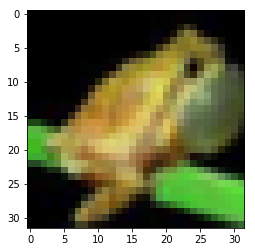

In [21]:
plt.imshow(data.trn_ds.denorm(x)[0])

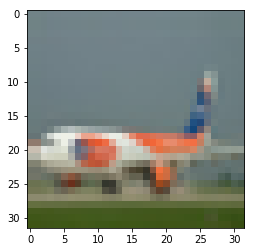

In [22]:
plt.imshow(data.trn_ds.denorm(x)[1])

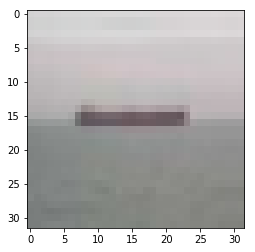

In [23]:
plt.imshow(data.trn_ds.denorm(x)[2])

## Fully connected model

In [24]:
data = get_data(32, bs)

In [44]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        # minibatch size conserved, rest flattened
        x = x.view(x.size(0), -1)
        for l in self.layers:
            x = F.relu(l(x))
        return F.log_softmax(x, dim=-1)

In [45]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40, 10]), data)

In [46]:
learn

SimpleNet(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=10, bias=True)
  )
)

In [47]:
[l.numel() for l in learn.model.parameters()]
# weights first layer, bias first layer, weights output layer, bias output layer

[122880, 40, 400, 10]

In [48]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [49]:
learn.lr_find()

epoch      trn_loss   val_loss   accuracy                   
    0      2.244108   2.302585   0.1       



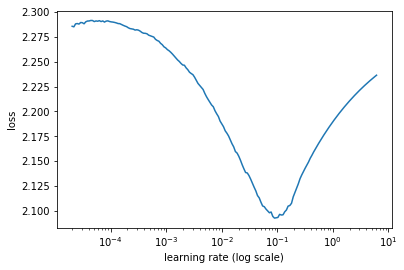

In [50]:
learn.sched.plot()

In [52]:
lr = 2e-2

In [53]:
%time learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.783729   1.671426   0.4073    
    1      1.690334   1.572153   0.4398                     

CPU times: user 2min 29s, sys: 23.7 s, total: 2min 53s
Wall time: 34.3 s


[array([1.57215]), 0.4398]

In [54]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.590282   1.485381   0.4773    
    1      1.569007   1.466308   0.4848                     

CPU times: user 2min 26s, sys: 24.3 s, total: 2min 50s
Wall time: 37.2 s


[array([1.46631]), 0.4848]

## ConvNet

In [55]:
class ConvNet(nn.Module):
    def __init__(self, layers, n_out):
        super().__init__()
        self.layers = nn.ModuleList([nn.Conv2d(in_channels=layers[i], out_channels=layers[i + 1], kernel_size=3, stride=2) for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(output_size=1)
        self.out = nn.Linear(layers[-1], n_out)
        
    def forward(self, x):
        for l in self.layers:
            x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

**AdaptiveMaxPool means that the output size is fixed while the input size can vary. One by one adaptive max pool usually used in the penultimate layer of fully convolutional architectures.**

In [63]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [64]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [65]:
learn.lr_find(end_lr=10)

 80%|███████▉  | 156/196 [00:12<00:03, 12.39it/s, loss=115] 

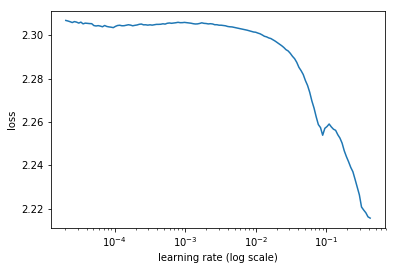

In [66]:
learn.sched.plot()

In [67]:
% time learn.fit(1e-1, 2)

 16%|█▌        | 31/196 [00:03<00:16,  9.80it/s, loss=2.16]
epoch      trn_loss   val_loss   accuracy                   
    0      1.696057   1.590924   0.4153    
    1      1.500337   1.424076   0.4918                     

CPU times: user 2min 32s, sys: 24 s, total: 2min 56s
Wall time: 34.3 s


[array([1.42408]), 0.4918]

In [68]:
% time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.337106   1.252252   0.5489    
    1      1.292416   1.207744   0.5662                     
    2      1.249593   1.170348   0.5799                     
    3      1.213217   1.136477   0.5938                     

CPU times: user 5min 6s, sys: 47.8 s, total: 5min 53s
Wall time: 1min 9s


[array([1.13648]), 0.5938]

Four times fewer parameters but 10% more accuracy.

## Let's add padding and refactor the last model to shorten the code

Padding=1 makes sure we reduce 32x32 to 16x16 instead of 15x15 as in the last model.

In [86]:
# Put defaults in layer definition

class ConvLayer(nn.Module):
    def __init__(self, f_in, f_out):
        super().__init__()
        self.conv = nn.Conv2d(f_in, f_out, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        return F.relu(self.conv(x))

In [81]:
class ConvNet2(nn.Module):
    def __init__(self, layers, n_out):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], n_out)
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        # preserve minibatch size, flatten rest
        x = x.view(x.size(0), -1)
        
        return F.log_softmax(self.out(x), dim=-1)

In [82]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [83]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [84]:
% time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.702102   1.756182   0.3846    
    1      1.510568   1.425706   0.4867                     

CPU times: user 2min 33s, sys: 23.6 s, total: 2min 56s
Wall time: 34.2 s


[array([1.42571]), 0.4867]

In [85]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.300015   1.222579   0.5652    
    1      1.253193   1.179739   0.5771                     
    2      1.197974   1.141736   0.5916                     
    3      1.173729   1.112343   0.6071                     

CPU times: user 5min 8s, sys: 48.3 s, total: 5min 56s
Wall time: 1min 9s


[array([1.11234]), 0.6071]

Problem: when trying to add more layers, the model stops being resilient. Either the gradients explode, or the learning rate has to be so small, that it takes forever to train.

Solution: batch normalization

## Batch normalization
Proved to be crucial for training deep nets. The following model is going to be much deeper than the previous and still resilient to train.

Normalizes every layer and controls that the activations don't exponentially grow or vanish.

Instead of scaling a layer up (increasing every weight), SGD can simply increase the parameter m. Instead of shifting the weights up or down, it can increase or decrease a.

1. More resilient training
1. Allows larger learning rates
1. Allows deeper nets
1. Regularizes: often less dropout or weight decay necessary! The regularization probably comes from the fact that every minibatch is different, so that the mean and std deviation is different as well which adds noise...

In [185]:
# nn.BatchNorm2d. Here we do it from scratch
# Actually a simplified version. Full BatchNorm 
# uses exponentially decaying averages of mean and std
# of the filters
class BatchNormLayer(nn.Module):
    def __init__(self, f_in, f_out, stride=2, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(f_in, f_out, kernel_size=kernel_size, stride=stride, bias=False, padding=padding)
        self.a = nn.Parameter(torch.zeros(f_out, 1, 1))
        self.m = nn.Parameter(torch.ones(f_out, 1, 1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0, 1).contiguous().view(x.size(1), -1)  # num of filters
        if self.training:
            # mean and std of each filter
            self.means = x_chan.mean(1)[:, None, None]
            self.stds  = x_chan.std(1)[:, None, None]
        return (x-self.means) / self.stds * self.m + self.a
# If this was really intended to be used one should probably divide by (self.stds + eps)

In [121]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, n_out):
        super().__init__()
        self.conv1 = nn.Conv2d(3, layers[0], kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BatchNormLayer(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], n_out)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers:
            x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        # preserve minibatch size, flatten rest
        x = x.view(x.size(0), -1)
        
        return F.log_softmax(self.out(x), dim=-1)

In [122]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [123]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BatchNormLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BatchNormLayer-5',
             

In [124]:
learn.lr_find()

 78%|███████▊  | 153/196 [00:11<00:03, 13.01it/s, loss=nan] 

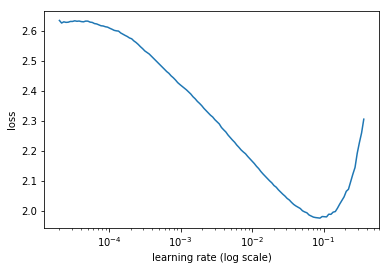

In [125]:
learn.sched.plot()

In [126]:
learn.fit(3e-2, 2)

 23%|██▎       | 45/196 [00:03<00:13, 11.26it/s, loss=1.87]
epoch      trn_loss   val_loss   accuracy                   
    0      1.496147   1.390415   0.5005    
    1      1.281947   1.167531   0.5787                     



[array([1.16753]), 0.5787]

In [127]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.164448   1.060637   0.6258    
    1      1.054636   0.933383   0.6709                     
    2      0.960631   0.875445   0.6872                      
    3      0.900813   0.824036   0.7091                      

CPU times: user 6min 2s, sys: 48.6 s, total: 6min 51s
Wall time: 1min 6s


[array([0.82404]), 0.7091]

In [129]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.848855   0.781855   0.7233    
    1      0.807261   0.766067   0.7304                      
    2      0.774059   0.756201   0.738                       
    3      0.752608   0.735999   0.745                       

CPU times: user 6min 2s, sys: 49.3 s, total: 6min 52s
Wall time: 1min 6s


[array([0.736]), 0.745]

### Attention: make sure that your library does not update the BatchNorm parameters a and m when the all layers but the last are frozen. Happens in many libraries because they only check if in training mode but not if frozen. Fastai also allows to unfreeze earlier layers and keep the BatchNorm parameters frozen (bn_freeze). Works well when the data we finetune on is similiar to data the network was pretrained on.

## Deep BatchNorm model

In [139]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, n_out):
        super().__init__()
        
        # first layer has a bigger filter:
        # all modern architectures start with a larger
        # filter like 5x5, 7x7 or even up to 11x11.
        # stride is 1 and padding is kernel_size//2
        # filter size will not change but more filters
        #  -> richer input to the network
        self.conv1 = nn.Conv2d(3, layers[0], kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BatchNormLayer(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self. layers2 = nn.ModuleList([BatchNormLayer(layers[i + 1], layers[i + 1], stride=1) for i in range(len(layers) - 1)])
        # stride 1 => doesn't change the size (kernel_size=3, padding=1)
        
        self.out = nn.Linear(layers[-1], n_out)
        
    def forward(self, x):
        x = self.conv1(x)
        for l, l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [140]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [141]:
% time learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.511038   1.369083   0.5021    
    1      1.293975   1.217385   0.5575                     

CPU times: user 3min 13s, sys: 25.4 s, total: 3min 39s
Wall time: 35 s


[array([1.21739]), 0.5575]

In [143]:
% time learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.980867   0.921074   0.6721    
    1      0.914814   0.903012   0.6806                      

CPU times: user 3min 16s, sys: 25.2 s, total: 3min 42s
Wall time: 35.7 s


[array([0.90301]), 0.6806]

**Did not really help! Too deep to handle even for batchnorm (12 layers). Solution: *resnet* blocks**

## Resnet

Instead of $a_{i+1} = f(a_{i})$ calculate $a_{i+1} =a_{i} + f(a_{i})$. 

Network learns how much it has to add ontop of the activations of the current layer to calculate the activations of the next layer.

$f(a_i) = \underbrace{a_{i+1} - a_{i}}_{\text{residual}}$

Resnet layer tries to learn a set of conv filters that estimate the residual/error/how much it was off by and adds that to the activations of the pref layer.

(keyword *boosting*)

In [147]:
class ResnetLayer(BatchNormLayer):
    def forward(self, x):
        return x + super().forward(x)

Full resnet block has two convolutions that get added to original input...

In [178]:
class Resnet(nn.Module):
    def __init__(self, layers, n_out):
        super().__init__()
        self.conv1 = nn.Conv2d(3, layers[0], kernel_size=5, stride=1, padding=2)
        
        # Bottleneck layer reduces the size
        self.layers = nn.ModuleList([BatchNormLayer(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i + 1], layers[i + 1], stride=1) for i in range(len(layers) - 1)])
        
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i + 1], layers[i + 1], stride=1) for i in range(len(layers) - 1)])
        
        self.out = nn.Linear(layers[-1], n_out)
        
    def forward(self, x):
        x = self.conv1(x)
        for l, l2, l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
            
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [179]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [180]:
wd = 1e-5

In [181]:
%time learn.fit(1e-2, 2, wds=wd)

 45%|████▍     | 88/196 [00:08<00:10,  9.96it/s, loss=1.84]
epoch      trn_loss   val_loss   accuracy                   
    0      1.576525   1.448838   0.463     
    1      1.361114   1.265466   0.5356                     

CPU times: user 3min 36s, sys: 26.7 s, total: 4min 2s
Wall time: 38.9 s


[array([1.26547]), 0.5356]

In [183]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.185055   1.101637   0.6028    
    1      1.111434   1.06314    0.6245                     
    2      0.998808   0.977068   0.6513                      
    3      1.027849   0.975656   0.6556                     
    4      0.906812   0.896426   0.6808                      
    5      0.822771   0.825362   0.7067                      
    6      0.796764   0.841008   0.7043                      

CPU times: user 12min 32s, sys: 1min 33s, total: 14min 5s
Wall time: 2min 15s


[array([0.84101]), 0.7043]

In [184]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.873156   0.840932   0.7053    
    1      0.795489   0.774087   0.7249                      
    2      0.717201   0.71873    0.7482                      
    3      0.669033   0.707185   0.7537                      
    4      0.775813   0.762757   0.7369                      
    5      0.70549    0.739103   0.7456                      
    6      0.621499   0.659228   0.7746                      
    7      0.578924   0.669779   0.772                       
    8      0.681729   0.715374   0.7505                      
    9      0.6251     0.644874   0.7748                      
    10     0.545657   0.624503   0.7876                      
    11     0.508989   0.621296   0.7892                      
    12     0.615765   0.686351   0.7705                      
    13     0.550705   0.639152   0.7823                      
    14     0.505529   0.590059   0.796                       
    15     0.459851   0.58

[array([0.53228]), 0.8235]

**Three times deeper than first BatchNorm model we created but trains beautifully! :)**

## Let's tweak this a little more...

In [189]:
class Resnet2(nn.Module):
    def __init__(self, layers, n_out, p = 0.5):
        super().__init__()
        self.conv1 = BatchNormLayer(3, layers[0], stride=1, kernel_size=7)  # padding = 3
        
        self.layers = nn.ModuleList([BatchNormLayer(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i + 1], layers[i + 1], stride=1) for i in range(len(layers) - 1)])
        
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i + 1], layers[i + 1], stride=1) for i in range(len(layers) - 1)])
        
        self.out = nn.Linear(layers[-1], n_out)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l, l2, l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
            
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [190]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 65, 128, 256], 10, 0.2), data)

In [191]:
wd = 1e-6

In [192]:
% time learn.fit(lrs=1e-2, n_cycle=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.627052   1.482385   0.4644    
    1      1.399879   1.261052   0.5447                     

CPU times: user 3min 47s, sys: 28.4 s, total: 4min 15s
Wall time: 41.4 s


[array([1.26105]), 0.5447]

In [193]:
% time learn.fit(lrs=1e-2, n_cycle=3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.192086   1.145631   0.5898    
    1      1.138265   1.101608   0.6141                     
    2      1.003317   0.957184   0.6625                     
    3      1.061927   1.022754   0.6477                     
    4      0.945411   0.916022   0.6819                      
    5      0.838307   0.801131   0.7169                      
    6      0.791739   0.804649   0.7185                      

CPU times: user 13min 22s, sys: 1min 38s, total: 15min
Wall time: 2min 24s


[array([0.80465]), 0.7185]

In [199]:
% time learn.fit(lrs=1e-2, n_cycle=8, cycle_len=4, cycle_mult=1, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.887833   0.882731   0.6931    
    1      0.809342   0.788145   0.723                       
    2      0.714211   0.707529   0.7515                      
    3      0.673939   0.696332   0.7539                      
    4      0.794014   0.754859   0.7393                      
    5      0.710952   0.681661   0.7615                      
    6      0.625848   0.672974   0.7707                      
    7      0.585995   0.636027   0.78                        
    8      0.71474    0.704283   0.7551                      
    9      0.629979   0.672416   0.7711                      
    10     0.567307   0.610239   0.7931                      
    11     0.522102   0.598643   0.793                       
    12     0.637208   0.629912   0.7825                      
    13     0.577492   0.622961   0.7873                      
    14     0.519527   0.556991   0.8105                      
    15     0.474265   0.56

[array([0.49073]), 0.8369]

In [200]:
learn.save('final')

In [201]:
log_preds, y = learn.TTA()

In [202]:
log_preds.shape

(5, 10000, 10)

In [203]:
preds = np.mean(np.exp(log_preds), axis=0)

In [217]:
metrics.log_loss(y, preds), (np.argmax(preds, axis=1) == y).mean()

(0.4413704039683223, 0.8488)